<figure>
  <img style="float: left;" src="./figures/unine.png" width="200"/>
</figure>

<figure>
  <img style="float: left;" src="./figures/fair_1.png" width="200"/>
</figure>

# Fairness

Machine learning (ML) usage is increasing every day. Companies and organisations build ML models with the purpose of minimising human effort or improving performance in various tasks. So today Machine learning arguably affects our lives.

Examples:
1. Recommendation system
2. Face recognition
3. Self-driving cars
4. Candidate selection e.x college admissions, CV screening
5. Loan admissions

There are a lot of examples that researchers demonstrate inadvertently discriminating against several population groups.    
The most know is [ProPublica's](https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis) research in COMPAS Dataset.

When machine learning models are being used to make decisions, they cannot be separated from the social and ethical context in which they are applied, and those developing and deploying these models must take care to do so in a manner that accounts for both performance and fairness. 

So in the last decade Fairness has become one of the most active research areas in ML.

# A2. Sources of Bias.

Bias may be introduced into a machine learning project at any step along the way, and it is important to carefully think through each potential source and how it may affect your results.


Source of bias:
- Data
    1. Historical injustice.
    2. Sample bias - Collection Bias.
    3. Limited features.
    4. Unbalanced dataset.
    5. Proxy Variables.
- Modelling
    1. Data preprocessing
    2. Model assumptions 
- Feedback loops.
    1. decisions based on biassed models lead to biassed dataset.  

<figure>
  <img style="float: left;" src="./figures/simple_pipeline.png" width="600"/>
</figure>


# A3. Load Dataset

https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

In [3]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binary target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)
    
    # Categorical dataset
    categorical_features = data.select_dtypes('category').columns
    data[categorical_features] = data.select_dtypes('category').apply(lambda x: x.cat.codes)
    return data

### load & clean dataset

In [4]:
# get and clean train dataset
TRAIN_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
train_data = train_data.dropna()
print("Train dataset shape:", train_data.shape)

# get and clean test dataset
TEST_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
test_data = test_data.dropna()
print("Test dataset shape:", test_data.shape)

Train dataset shape: (28938, 14)
Test dataset shape: (15175, 14)


In [5]:
train_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,6,9,13,4,0,1,4,1,2174.0,0,40,38,0
1,50,5,9,13,2,3,0,4,1,0.0,0,13,38,0
2,38,3,11,9,0,5,1,4,1,0.0,0,40,38,0
3,53,3,1,7,2,5,0,2,1,0.0,0,40,38,0
4,28,3,9,13,2,9,5,2,0,0.0,0,40,4,0


### Data analysis

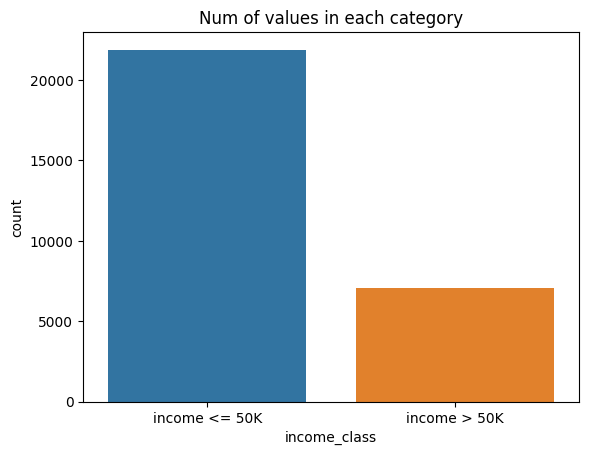

In [6]:
plt.figure()
fig = sns.countplot(x=train_data["income_class"])
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.title("Num of values in each category")
plt.show()
plt.close()

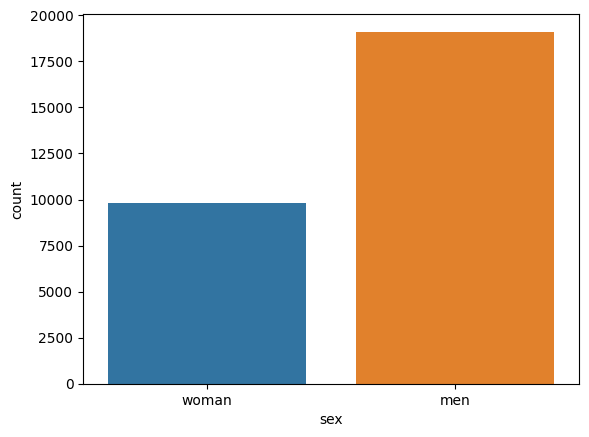

In [7]:
plt.figure()
fig = sns.countplot(x=train_data["sex"])
fig.set_xticklabels(['woman','men'])
# plt.title("gender")
plt.show()
plt.close()

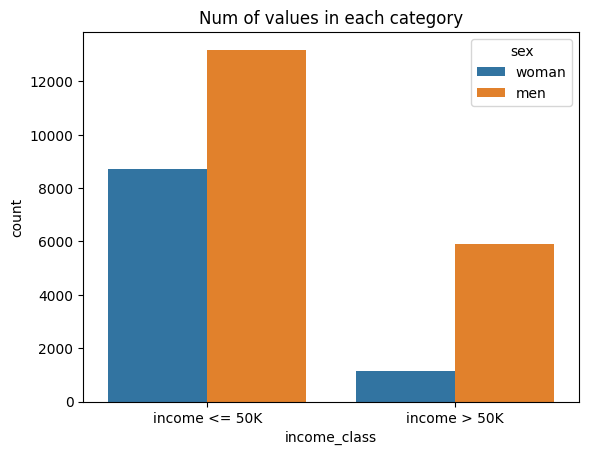

In [8]:
plt.figure()
fig = sns.countplot(data=train_data[["income_class","sex"]],
                    x="income_class",
                    hue="sex")
fig.set_xticklabels(['income <= 50K','income > 50K'])
plt.legend(title='sex', labels=['woman', 'men'])
plt.title("Num of values in each category")
plt.show()
plt.close()

The dataset is quite imbalance between a gender, so we expect our model to be unfair.
The source of the bias is coming from our societal bias.

# A4. Train a Model
let's train our model and analyse the results.

In [9]:
features = train_data.columns.difference([target_column])

# we define sex as our sensitive feature
sensitive_feature = ["sex"]

# all the rest are non sensitive feature
non_sensitive_features = list(set(features).difference(set(sensitive_feature)))

In [10]:
from sklearn.ensemble import RandomForestClassifier

model  = RandomForestClassifier(n_estimators=1000,
                                max_depth=10)

model.fit(X = train_data[sensitive_feature+non_sensitive_features],
          y = train_data[target_column])

RandomForestClassifier(max_depth=10, n_estimators=1000)

# Measure performance scores

Bellow are some of the most know mesurements scores


>1. Accuracy: $\frac{TP+TN}{TN + FP + FN + TP}$  
2. Recall: $\frac{TP}{ TP + FN }$  
3. Precision: $\frac{TP}{ TP + FP }$  
4. F1-score: $2* \frac{ Recall * Precision}{Precision + Recall}$  

<div>
<img style="float: left;" src="./figures/conf_matrix.png" width="300"/>
</div>

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [12]:
conf_matrix = confusion_matrix(y_true = test_data[target_column],
                               y_pred = model.predict(test_data[sensitive_feature+non_sensitive_features]))
conf_matrix = pd.DataFrame(conf_matrix)

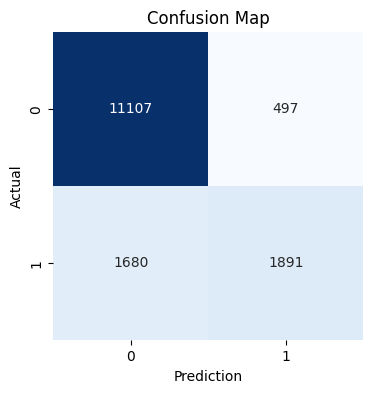

In [13]:
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='g', cbar=False, cmap="Blues")
plt.title("Confusion Map")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [14]:
TN, FP, FN, TP = conf_matrix.values.ravel()

acc_score = 
precision_score = TP / (TP + FP)
recall_score = TP / (TP + FN)
f1_score = 2*(precision_score*recall_score)/(precision_score+recall_score)

print("accuracy score:", acc_score)
print("precision score:", precision_score)
print("recall score:", recall_score)
print("f1 score:", recall_score)

accuracy score: 0.8565403624382207
precision score: 0.7918760469011725
recall score: 0.529543545225427
f1 score: 0.529543545225427


In [15]:
acc_score = accuracy_score(y_true = test_data[target_column],
                           y_pred = model.predict(test_data[sensitive_feature+non_sensitive_features]))
print("Accuracy_score:", acc_score)

Accuracy_score: 0.8565403624382207


# A5. Analysis of model fairness


Unfortunately there is not a single definition of fairness. There are many, often competing, ways to measure whether a given model is statistically “fair”, but it’s important to remember to start from the social and policy goals for equity and fairness and map those to the statistical properties we want in our models to help achieve those goals. Most of the definitions involve splitting the population into groups and compare metrics on those groups.

Different definition preserve different fairness aspects. So the desired fairness definition is depending on the application. In general, this requires consideration of the project’s goals, and a detailed discussion between the data scientists, decision makers, and those who will be affected by the application of the model.

Bellow we will define the most known fairness definitions.

1. **Demographic Parity** - equal positive outcome rates
2. **Equalized Opportunities** - equal true positive  rates
3. **Equalized Odds** -  equal true positive and false positive rate
4. **Predictive Parity** - equal Positive precision  
.  
.  
.  

In [16]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
predictions = pd.Series(predictions,index = test_data.index)
sensitive_atribute = test_data[sensitive_feature[0]]

In [17]:
woman_mask = sensitive_atribute == 0
conf_matrix_0 = confusion_matrix(y_true = test_data.loc[woman_mask,target_column],
                                 y_pred = predictions.loc[woman_mask])
conf_matrix_0 = pd.DataFrame(conf_matrix_0)

In [18]:
man_mask = sensitive_atribute == 1
conf_matrix_1 = confusion_matrix(y_true = test_data.loc[man_mask,target_column],
                                 y_pred = predictions.loc[man_mask])
conf_matrix_1 = pd.DataFrame(conf_matrix_1)

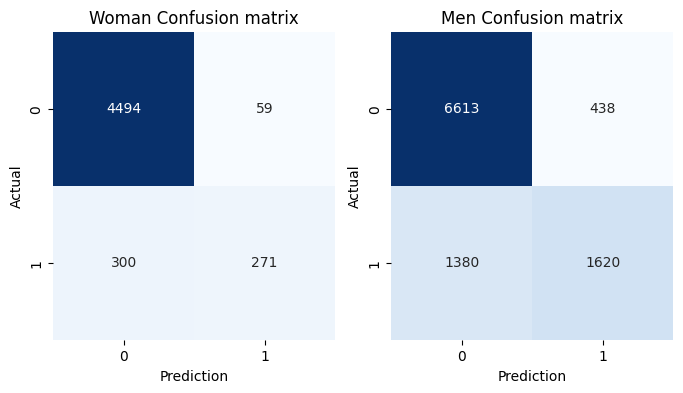

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (8,4))
sns.heatmap(conf_matrix_0, annot=True, fmt='g', cbar=False, cmap="Blues", ax=axes[0])
axes[0].set_title("Woman Confusion matrix")
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Prediction')

sns.heatmap(conf_matrix_1, annot=True, fmt='g', cbar=False, cmap="Blues", ax=axes[1])
axes[1].set_title("Men Confusion matrix")
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Prediction')
plt.show()
plt.close()

## F1.  Demographic Parity

**Demographic parity** , also referred to as **statistical parity** , **acceptance rate parity**  and **benchmarking**

Demographic Parity states that the positive outcome rates between sensitive group must be the same.

---------------
> **Definition Demographic Parity :** A classifier $C$ is said that satisfy **demographic parity** if $$ P_c(\hat{Y}= 1 | S = s ) =  P_c(\hat{Y} = 1), \quad  \forall s\in S $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we can also equivalent write:
$$ P_c(\hat{Y}= 1 | S = 0 ) =  P_c(\hat{Y}= 1 | S = 1 ) $$  
---------------

**How to measure Demographic parity?**

we can measure the Demographic parity using the Demographic parity difference metric.

> **Demographic parity difference :** we can measure the demographic parity using the next formula:
  $$  \text{Metric} =  max_s[P_c(\hat{Y}= 1 | S = s )] -  min_s[P_c(\hat{Y}= 1 | S = s )] $$  

In [20]:
def demographic_parity_difference(predictions, sensitive_attribute):
    """
    Implementation of demographic parity difference for different groups of sensitive attribute
    1. For each group calculate the propotion of accepted rate.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the proportion of accepted rate.
    unique_groups = np.sort(sensitive_attribute.unique())
    proportion_of_accepted_rate = []
    for group in unique_groups:
        pred_group = predictions[sensitive_attribute==group]
        accepted_rate = #Calculate the accepted rate
        proportion_of_accepted_rate += [accepted_rate]

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_accepted_rate = max(proportion_of_accepted_rate)
    minimum_accepted_rate = min(proportion_of_accepted_rate)

    # 3. Calculate the different.
    difference = maximum_accepted_rate - minimum_accepted_rate
    
    return difference, proportion_of_accepted_rate

SyntaxError: invalid syntax (763441869.py, line 13)

In [ ]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]

In [ ]:
demographic_metric, rates = demographic_parity_difference(predictions, sensitive_attribute)

In [ ]:
print(f"Demographic parity difference is: {round(demographic_metric,5)}")

In [ ]:
print(f"The rate of different groups are: {rates}")

---------------
**When to use demographic parity?** 
1. We are aware of **historical biases** that may have affected the quality of our data. E.x not presents of specific minority in a specific work.
2. We want to **change the state of our current world to improve it**. For example, we want to have equal admitions of different group in a specific project.


**Potential issues?** 
1. **Laziness**: We can satisfy demographic parity in we accept random people in group S=0 but qualified people in group  b unless we have the same proportion of positive outcome. We avoid lasyness because classfication is usually perfomred by optimizing an perfomance metric.
2. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F2. Equalized Opotunities

**Equalized Opportunities** , also referred to as **true positive parity**, **sensitivity**.

Equalized Opportunities states that each group has equal true positive rates.

---------------
> **Definition Equalized Opotunities :** A classifire $C$ is said that satisfy **equalized opotunities** if $$ P_c(\hat{Y} = 1 | S = s, Y = 1 ) =  P_c(\hat{Y} = 1 | Y = 1), \quad  \forall s\in S $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we can also equivalent write:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$  
---------------

**How to measure Equalized Opportunities?**

we can measure the equalized Opportunities using the equalized opportunities difference metric.

> **equalized opportunities difference :** we can measure the equalized opportunities using the next formula:
  $$  \text{Metric} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] $$  

**Hint**

> **True Positive Rate** : To calculate the $P_c(\hat{Y}= 1 | Y = 1 )$ you can do the following:
  $$  P_c(\hat{Y}= 1 | Y = 1 ) = \frac{P_c(\hat{Y}= 1, Y = 1 )}{P_c( Y = 1 )} = \frac{TP}{P} = \frac{TP}{TP+FN} $$ 

In [ ]:
def equalized_opportunities_difference(predictions, actual, sensitive_attribute):
    """
    Implementation of equalized opportunities difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calculate the difference.
    """
    # 1. For each group calculate the TPR.
    unique_groups = np.sort(sensitive_attribute.unique())
    true_positive_rates = []
    for group in unique_groups:
        # calculate the true positve rate and store it in the true_positive_rates list

    # 2. Find the maximum and the minimum accepted_rate.
    maximum_tpr = max(true_positive_rates)
    minimum_tpr = min(true_positive_rates)

    # 3. Calculate the different.
    difference = maximum_tpr - minimum_tpr
    
    return difference, true_positive_rates

In [ ]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]
actual = test_data[target_column]

In [ ]:
equalized_opportunities_metric, _ = equalized_opportunities_difference(predictions, actual, sensitive_attribute)

In [ ]:
print(f"equalized opportunities difference is: {round(equalized_opportunities_metric,5)}")

---------------
**When to use equalized opportunities?**
1. When is a strong emphasis on predicting the positive outcome correctly. e.x college admissions
2. When False Positives are not costly for the stakeholder. e.x spam detection

**Potential issues?** 
1. **Not optimality compatible**: A classifier that satisfy demographic parity is suboptimal, if the dataset demographic parity is not hold.
---------------

## F3. Equalized Odds

**Equalized Odds** , also referred to as

Equalized Odds states that the true positive rates (TPR) and false positive rates (FPR) between sensitive group must be the same.

- TPR = TP / total_positives  = TP / (TP+FN)
- FPR = FP / total_negatives = FP / (FP+TN)
---------------
> **Definition Equalized Odds :** A classifier $C$ is said that satisfy **equalized odds** if $$ P_c(\hat{Y} = 1 | S = s, Y = y ) =  P_c(\hat{Y} = 1 | Y = y), \quad  \forall s\in S, \forall y\in Y $$
in case of 2 sensitive classes, $ s \in \{0,1\}  $ we want to satisfy both:
$$ P_c(\hat{Y}= 1 | S = 0, Y = 1 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 1 ) $$ 
and 
$$ P_c(\hat{Y}= 1 | S = 0, Y = 0 ) =  P_c(\hat{Y}= 1 | S = 1, Y = 0 ) $$  
---------------

**How to measure Equalized Opportunities?**

we can measure the equalized Opportunities using the equalized opportunities difference metric.

> **equalized opportunities difference :** we can measure the equalized opportunities using the next formula:
  $$   \text{Metric} = \text{true_positive_rate_difference} + \text{false_positive_rate_difference}  $$
where
  $$ \text{true_positive_rate_difference} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 1 )] $$ 
  $$ \text{false_positive_rate_difference} =  max_s[P_c(\hat{Y}= 1 | S = s, Y = 0 )] -  min_s[P_c(\hat{Y}= 1 | S = s, Y = 0 )] $$  

In [ ]:
def equalized_odds_difference(predictions, actual, sensitive_attribute):
    """
    Implementation of equalized odds difference for different groups of sensitive attribute
    1. For each group calculate the TPR.
    2. Find the maximum and the minim group.
    3. Calcaulte the difference.
    """
    # 1. For each group calculate the TPR.
    unique_groups = np.sort(sensitive_attribute.unique())
    true_positive_rates = []
    false_positive_rates = []
    for group in unique_groups:
        # calculate true positive and false positive rate and store in the list

    # 2. Find the maximum and the minimum rates.
    maximum_tpr = # find the max true positive rates
    minimum_tpr = # find the min true positive rates
    
    maximum_fpr = # find the max false positive rates
    minimum_fpr = # find the min false positive rates

    # 3. Calculate the different.
    difference_tpr = # calculate difference of true positive rates
    difference_fpr = # calculate difference of false positive rates
    difference = # sum the difference
    
    return difference, (true_positive_rates,false_positive_rates)

In [ ]:
predictions = model.predict(test_data[sensitive_feature+non_sensitive_features])
sensitive_attribute = test_data["sex"]
actual = test_data[target_column]

In [ ]:
equalized_odds_metrics, _ = equalized_odds_difference(predictions, actual, sensitive_attribute)

In [ ]:
print(f"equalized odds difference is: {round(equalized_odds_metrics,5)}")

In [ ]:
results = pd.DataFrame([acc_score,
                        precision_score,
                        recall_score,
                        f1_score,
                        demographic_metric,
                        equalized_opportunities_metric,
                        equalized_odds_metrics], 
                       index = ["accuracy",
                                "precision",
                                "recall",
                                "f1_score",
                                "demographic_metric",
                                "equalized_opportunities",
                                "equalized_odds"],
                       columns = ["model"])

----------------
**When to use equalized odds?** 
1. When is a strong emphasis on predicting the positive outcome correctly. e.x college admissions
2. When we strongly care about minimising costly False Positives

**Potential issues?** 
1. **Not optimality compatible**: A classifier that satisfy equalized odds is suboptimal, if the dataset demographic parity is not hold. Its more constrained than the equal opportunities, so the effect on perforce will be stronger
---------------

For your project you have explained why you choose the specific fairness criteria.

# B. Try to fix unfairness

In [ ]:
def compute_metric(y_pred, y_true, sensitive_feature):
    
    conf_matrix = confusion_matrix(y_true = y_true,
                                   y_pred = y_pred)
    conf_matrix = pd.DataFrame(conf_matrix)

    TN, FP, FN, TP = conf_matrix.values.ravel()

    acc_score = ( TN + TP ) / (TN + FP + FN + TP)
    precision_score = TP  / (TP + FP)
    recall_score = TP  / (TP + FN)
    f1_score = 2*(precision_score*recall_score)/(precision_score+recall_score)
    
    demographic_metric, _ = demographic_parity_difference(y_pred,
                                                          sensitive_feature)
    
    equalized_opportunities_metric, _ = equalized_opportunities_difference(y_pred,
                                                                           y_true,
                                                                          sensitive_feature)
    equalized_odds_metrics, _ = equalized_odds_difference(y_pred,
                                                          y_true,
                                                          sensitive_feature)
    
    return {
            "accuracy": acc_score,
            "precision": precision_score,
            "recall": recall_score,
            "f1_score": f1_score,
            "demographic_metric": demographic_metric,
            "equalized_opportunities" : equalized_opportunities_metric,
            "equalized_odds": equalized_odds_metrics
            }

# B1. Unawareness
A very intuitive but wrong solution is to assume that ignoring the sensitive feature we can build a fair classifier.
This approach is wrong because other feature may be correlated with our sensitive features.

We will build a **Unawareness** classifier and the compare the results with our previous classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

unaware_model  = RandomForestClassifier(n_estimators=1000,
                                        max_depth=10)

unaware_model.fit(X = train_data[non_sensitive_features],
                  y = train_data[target_column])

In [ ]:
unaware_model.predict(test_data[non_sensitive_features])

In [ ]:
unaware_metrics = compute_metric(y_pred = unaware_model.predict(test_data[non_sensitive_features]),
                                 y_true = test_data[target_column],
                                 sensitive_feature = test_data["sex"])

In [ ]:
unaware_results = pd.DataFrame(unaware_metrics,
                               index = ["unaware_model"]).T

In [ ]:
unaware_results

## Compare the results of 2 models

In [ ]:
all_results = pd.concat([results, unaware_results],axis=1)
all_results

### Conclusion
Our conclusion is that we are not able to vanish unfairness by excluding sensitive features.  
The reason in that some other feature leak information about our sensitive attribute.

## B.2 Post processing
From the above results we expect that our sensitive feature are correlate with non-sensitive feature in our analysis.
We will try to find and exclude also those feature in order to improve our fairness properties.

In [ ]:
corr = {}
for f in non_sensitive_features:
    corr[f] =np.corrcoef(test_data[sensitive_feature[0]], test_data[f])[0,1]
corr = np.abs(pd.DataFrame(data=corr, index=["corr"]).T).sort_values(by="corr",ascending = False)

In [ ]:
plt.figure()
corr.plot(kind="bar")
plt.title("Correlation of sensitive attribute")
plt.show()
plt.close()

#### build classifier excluding k most correlated feature

In [ ]:
k=3
k_most_correlated = corr.iloc[0:k].index.values.tolist()

In [ ]:
for i in range(len(k_most_correlated)):
    print(f"===========iteration{i+1}===========")
    training_features = list(set(non_sensitive_features).difference(set(k_most_correlated[0:i+1])))
    print("We exclude from training: ", k_most_correlated[0:i+1])
    
    # 1. train
    post_processing_model  = RandomForestClassifier(n_estimators=1000,
                                                    max_depth=10)

    post_processing_model.fit(X = train_data[training_features],
                              y = train_data[target_column])
    

    # 2. compute matrix
    post_processing_metrics = compute_metric(y_pred= post_processing_model.predict(test_data[training_features]),
                                             y_true= test_data[target_column],
                                             sensitive_feature = test_data["sex"])
    
    # 3. append result
    post_processing_results = pd.DataFrame(post_processing_metrics,
                                           index = [f"post_prossesing_{i+1}"]).T
    
    all_results = pd.concat([all_results, post_processing_results],axis=1)

In [ ]:
all_results

In [ ]:
all_results.plot(kind="bar")

In [ ]:
all_results